<a href="https://colab.research.google.com/github/Amit-Prasad/re-identification/blob/main/LA_Transformer_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm
# !gdown --id 1qlvPquVLfP20neHYZ6cwzmzAw9s-O0Yf
!pip install faiss-cpu --no-cache
# !unzip Data.zip

     |████████████████████████████████| 376 kB 4.1 MB/s 
     |████████████████████████████████| 8.5 MB 4.2 MB/s 


In [ ]:
from __future__ import print_function

import os
import time
import random
import zipfile
from itertools import chain

import timm
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from LATransformer.model import ClassBlock, LATransformer
from LATransformer.utils import save_network, update_summary
from LATransformer.distance import compute_dist
from LATransformer.re_ranking import re_ranking
#from metric import cmc, mean_ap

# os.environ['CUDA_VISIBLE_DEVICES']='0'
device = "cuda"

In [ ]:
batch_size = 8
num_epochs = 30
lr = 3e-4
gamma = 0.7
unfreeze_after=2
lr_decay=.8
lmbd = 8

In [ ]:
transform_train_list = [
    transforms.Resize((224,224), interpolation=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
transform_val_list = [
    transforms.Resize(size=(224,224),interpolation=3), #Image.BICUBIC
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
data_transforms = {
'train': transforms.Compose( transform_train_list ),
'val': transforms.Compose(transform_val_list),
}

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
!unzip test-reid.zip

Archive:  test-reid.zip
   creating: test-reid/
   creating: test-reid/query/
   creating: test-reid/gallery/
   creating: test-reid/all_imgs/
   creating: test-reid/query/091/
  inflating: test-reid/query/091/01_6.png  
  inflating: test-reid/query/091/01_2.png  
   creating: test-reid/query/101/
  inflating: test-reid/query/101/02_5.png  
  inflating: test-reid/query/101/01_6.png  
   creating: test-reid/query/076/
  inflating: test-reid/query/076/02_1.png  
  inflating: test-reid/query/076/02_8.png  
   creating: test-reid/query/040/
  inflating: test-reid/query/040/01_8.png  
  inflating: test-reid/query/040/01_5.png  
  inflating: test-reid/query/040/02_3.png  
   creating: test-reid/query/108/
  inflating: test-reid/query/108/01_2.png  
  inflating: test-reid/query/108/02_1.png  
  inflating: test-reid/query/108/01_1.png  
   creating: test-reid/query/072/
  inflating: test-reid/query/072/02_2.png  
   creating: test-reid/query/026/
  inflating: test-reid/query/026/01_7.png  
  i

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/train/
   creating: data/train/001/
  inflating: data/train/001/01_1.png  
  inflating: data/train/001/01_2.png  
  inflating: data/train/001/01_3.png  
  inflating: data/train/001/01_4.png  
  inflating: data/train/001/01_5.png  
  inflating: data/train/001/01_6.png  
  inflating: data/train/001/01_7.png  
  inflating: data/train/001/01_8.png  
  inflating: data/train/001/02_1.png  
  inflating: data/train/001/02_2.png  
  inflating: data/train/001/02_3.png  
  inflating: data/train/001/02_4.png  
  inflating: data/train/001/02_5.png  
  inflating: data/train/001/02_6.png  
  inflating: data/train/001/02_7.png  
  inflating: data/train/001/02_8.png  
   creating: data/train/003/
  inflating: data/train/003/01_1.png  
  inflating: data/train/003/01_2.png  
  inflating: data/train/003/01_3.png  
  inflating: data/train/003/01_4.png  
  inflating: data/train/003/01_5.png  
  inflating: data/train/003/01_6.png  
  inflating: data/tra

In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def train_val_dataset(dataset, val_split=0.10):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

image_datasets = {}
data_dir = "/content/data"

data = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
data = train_val_dataset(data)

#image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'val'),
#                                          data_transforms['val'])
train_loader = DataLoader(dataset = data['train'], batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = data['val'], batch_size=batch_size, shuffle=True)
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=opt.batchsize,
#                                              shuffle=True, num_workers=8, pin_memory=True) # 8 workers may work faster
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#class_names = len(train_loader)


In [ ]:
# Load pre-trained ViT
vit_base = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=62) #62 karna hai
vit_base= vit_base.to(device)
vit_base.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def validate(model, loader, loss_fn):
    batch_time_m = AverageMeter()
    losses_m = AverageMeter()
    top1_m = AverageMeter()
    top5_m = AverageMeter()

    model.eval()
    epoch_accuracy = 0
    epoch_loss = 0
    end = time.time()
    last_idx = len(loader) - 1

    running_loss = 0.0
    running_corrects = 0.0

    with torch.no_grad():
        for input, target in tqdm(loader):

            input, target = input.to(device), target.to(device)

            output = model(input)

            score = 0.0
            sm = nn.Softmax(dim=1)
            for k, v in output.items():
                score += sm(output[k])
            _, preds = torch.max(score.data, 1)

            loss = 0.0
            for k,v in output.items():
                loss += loss_fn(output[k], target)


            batch_time_m.update(time.time() - end)
            acc = (preds == target.data).float().mean()
            epoch_loss += loss/len(loader)
            epoch_accuracy += acc / len(loader)

            print(f"Epoch : {epoch+1} - val_loss : {epoch_loss:.4f} - val_acc: {epoch_accuracy:.4f}", end="\r")
    print()
    metrics = OrderedDict([('val_loss', epoch_loss.data.item()), ("val_accuracy", epoch_accuracy.data.item())])


    return metrics

In [ ]:
def train_one_epoch(
        epoch, model, loader, optimizer, loss_fn,
        lr_scheduler=None, saver=None, output_dir='',
        loss_scaler=None, model_ema=None, mixup_fn=None):




    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    losses_m = AverageMeter()

    model.train()
    epoch_accuracy = 0
    epoch_loss = 0
    end = time.time()
    last_idx = len(loader) - 1
    num_updates = epoch * len(loader)
    running_loss = 0.0
    running_corrects = 0.0

    for data, target in tqdm(loader):
        data, target = data.to(device), target.to(device)


        data_time_m.update(time.time() - end)

        optimizer.zero_grad()
        output = model(data)
        score = 0.0
        sm = nn.Softmax(dim=1)
        for k, v in output.items():
            score += sm(output[k])
        _, preds = torch.max(score.data, 1)

        loss = 0.0
        for k,v in output.items():
            loss += loss_fn(output[k], target)
        loss.backward()

        optimizer.step()

        batch_time_m.update(time.time() - end)

#         print(preds, target.data)
        acc = (preds == target.data).float().mean()

#         print(acc)
        epoch_loss += loss/len(loader)
        epoch_accuracy += acc / len(loader)
#         if acc:
#             print(acc, epreds, target.data)
        print(
    f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}"
, end="\r")

    print()

    return OrderedDict([('train_loss', epoch_loss.data.item()), ("train_accuracy", epoch_accuracy.data.item())])


In [ ]:
def freeze_all_blocks(model):
    frozen_blocks = 12
    for block in model.model.blocks[:frozen_blocks]:
        for param in block.parameters():
            param.requires_grad=False


In [ ]:
def unfreeze_blocks(model, amount= 1):

    for block in model.model.blocks[11-amount:]:
        for param in block.parameters():
            param.requires_grad=True
    return model

In [ ]:
# Create LA Transformer
model = LATransformer(vit_base, lmbd).to(device)
print(model.eval())

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(),weight_decay=5e-4, lr=lr)

# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
freeze_all_blocks(model)

LATransformer(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
      

In [ ]:
!cp /content/drive/MyDrive/net_best.pth /content/model/la_with_lmbd_8

In [ ]:
import os
best_acc = 0.0
y_loss = {} # loss history
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []
print("training...")
output_dir = ""
best_acc = 0
name = "la_with_lmbd_{}".format(lmbd)
'''
try:
    os.mkdirs("model/" + name)

except:
    pass
'''
output_dir = "/content/model/" + name
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
unfrozen_blocks = 0

for epoch in range(num_epochs):

    if epoch%unfreeze_after==0:
        unfrozen_blocks += 1
        model = unfreeze_blocks(model, unfrozen_blocks)
        optimizer.param_groups[0]['lr'] *= lr_decay
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print("Unfrozen Blocks: {}, Current lr: {}, Trainable Params: {}".format(unfrozen_blocks,
                                                                             optimizer.param_groups[0]['lr'],
                                                                             trainable_params))

    train_metrics = train_one_epoch(
        epoch, model, train_loader, optimizer, criterion,
        lr_scheduler=None, saver=None)

    eval_metrics = validate(model, valid_loader, criterion)


    # update summary
    update_summary(epoch, train_metrics, eval_metrics, os.path.join(output_dir, 'summary.csv'),
                   write_header=True)

    # deep copy the model
    last_model_wts = model.state_dict()
    if eval_metrics['val_accuracy'] > best_acc:
        best_acc = eval_metrics['val_accuracy']
        save_network(model, epoch,name)
        print("SAVED!")

training...
Unfrozen Blocks: 1, Current lr: 0.00023999999999999998, Trainable Params: 20432976


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 1 - loss : 90.1300 - acc: 0.1060


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 1 - val_loss : 85.5598 - val_acc: 0.1058
SAVED!


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 2 - loss : 79.1168 - acc: 0.1150


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 2 - val_loss : 73.8904 - val_acc: 0.0769
Unfrozen Blocks: 2, Current lr: 0.000192, Trainable Params: 27520848


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 3 - loss : 67.1107 - acc: 0.1842


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 3 - val_loss : 62.9093 - val_acc: 0.0673


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 4 - loss : 56.6184 - acc: 0.2623


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 4 - val_loss : 53.8939 - val_acc: 0.1827
SAVED!
Unfrozen Blocks: 3, Current lr: 0.00015360000000000002, Trainable Params: 34608720


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 5 - loss : 47.4947 - acc: 0.3471


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 5 - val_loss : 46.6460 - val_acc: 0.2692
SAVED!


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 6 - loss : 41.0681 - acc: 0.4252


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 6 - val_loss : 37.7764 - val_acc: 0.3654
SAVED!
Unfrozen Blocks: 4, Current lr: 0.00012288000000000002, Trainable Params: 41696592


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 7 - loss : 35.9149 - acc: 0.5033


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 7 - val_loss : 32.9558 - val_acc: 0.4327
SAVED!


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 8 - loss : 31.3256 - acc: 0.5915


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 8 - val_loss : 27.3365 - val_acc: 0.6442
SAVED!
Unfrozen Blocks: 5, Current lr: 9.830400000000001e-05, Trainable Params: 48784464


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 9 - loss : 27.7358 - acc: 0.6719


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 9 - val_loss : 26.3069 - val_acc: 0.7500
SAVED!


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 10 - loss : 25.1896 - acc: 0.7154


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 10 - val_loss : 23.7994 - val_acc: 0.7404
Unfrozen Blocks: 6, Current lr: 7.864320000000001e-05, Trainable Params: 55872336


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 11 - loss : 22.7813 - acc: 0.7679


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 11 - val_loss : 22.2340 - val_acc: 0.7019


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 12 - loss : 20.8342 - acc: 0.7958


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 12 - val_loss : 19.2333 - val_acc: 0.7596
SAVED!
Unfrozen Blocks: 7, Current lr: 6.291456000000001e-05, Trainable Params: 62960208


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 13 - loss : 18.6379 - acc: 0.8594


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 13 - val_loss : 18.0988 - val_acc: 0.7788
SAVED!


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 14 - loss : 17.8436 - acc: 0.8661


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 14 - val_loss : 16.6955 - val_acc: 0.7885
SAVED!
Unfrozen Blocks: 8, Current lr: 5.0331648000000016e-05, Trainable Params: 70048080


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 15 - loss : 15.9955 - acc: 0.9141


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 15 - val_loss : 15.6472 - val_acc: 0.7981
SAVED!


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 16 - loss : 15.4200 - acc: 0.8962


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 16 - val_loss : 13.9527 - val_acc: 0.7981
Unfrozen Blocks: 9, Current lr: 4.026531840000002e-05, Trainable Params: 77135952


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 17 - loss : 13.9736 - acc: 0.9330


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 17 - val_loss : 13.6777 - val_acc: 0.8365
SAVED!


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 18 - loss : 13.3587 - acc: 0.9397


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 18 - val_loss : 12.3549 - val_acc: 0.8558
SAVED!
Unfrozen Blocks: 10, Current lr: 3.221225472000002e-05, Trainable Params: 84223824


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 19 - loss : 12.7184 - acc: 0.9442


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 19 - val_loss : 11.6310 - val_acc: 0.8942
SAVED!


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 20 - loss : 12.3407 - acc: 0.9531


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 20 - val_loss : 11.8677 - val_acc: 0.8558
Unfrozen Blocks: 11, Current lr: 2.5769803776000016e-05, Trainable Params: 91311696


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 21 - loss : 11.3980 - acc: 0.9621


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 21 - val_loss : 10.5830 - val_acc: 0.9038
SAVED!


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 22 - loss : 11.2039 - acc: 0.9665


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 22 - val_loss : 10.3114 - val_acc: 0.8462
Unfrozen Blocks: 12, Current lr: 2.0615843020800013e-05, Trainable Params: 91311696


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 23 - loss : 11.1262 - acc: 0.9710


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 23 - val_loss : 10.0870 - val_acc: 0.9135
SAVED!


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 24 - loss : 9.9292 - acc: 0.9777


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 24 - val_loss : 10.1026 - val_acc: 0.9038
Unfrozen Blocks: 13, Current lr: 1.649267441664001e-05, Trainable Params: 91311696


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 25 - loss : 9.7177 - acc: 0.9754


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 25 - val_loss : 9.5058 - val_acc: 0.8846


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 26 - loss : 10.0036 - acc: 0.9833


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 26 - val_loss : 9.2097 - val_acc: 0.8942
Unfrozen Blocks: 14, Current lr: 1.319413953331201e-05, Trainable Params: 91311696


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 27 - loss : 9.9859 - acc: 0.9688


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 27 - val_loss : 9.1364 - val_acc: 0.8846


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 28 - loss : 9.2833 - acc: 0.9777


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 28 - val_loss : 8.7792 - val_acc: 0.8846
Unfrozen Blocks: 15, Current lr: 1.0555311626649608e-05, Trainable Params: 91311696


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 29 - loss : 9.2990 - acc: 0.9788


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 29 - val_loss : 8.7203 - val_acc: 0.8654


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch : 30 - loss : 9.1928 - acc: 0.9799


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 30 - val_loss : 8.0740 - val_acc: 0.8846


In [ ]:
from LATransformer.model import ClassBlock, LATransformer, LATransformerTest
from LATransformer.utils import save_network, update_summary, get_id
from LATransformer.metrics import rank1, rank5, rank10, calc_map

In [ ]:
batch_size = 8
gamma = 0.7
seed = 42

In [ ]:
!cp /content/drive/MyDrive/net_best.pth /content/model/la_with_lmbd_8

In [ ]:
# Load ViT
vit_base = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=62) #62
vit_base= vit_base.to(device)

# Create La-Transformer
model = LATransformerTest(vit_base, lmbd=8).to(device)

# Load LA-Transformer
name = "la_with_lmbd_8"
save_path = os.path.join('/content/model',name,'net_best.pth')
print(save_path)
model.load_state_dict(torch.load(save_path), strict=False)
model.eval()

/content/model/la_with_lmbd_8/net_best.pth


LATransformerTest(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
  

In [ ]:
transform_query_list = [
    transforms.Resize((224,224), interpolation=3),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
transform_gallery_list = [
    transforms.Resize(size=(224,224),interpolation=3), #Image.BICUBIC
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
data_transforms = {
'query': transforms.Compose( transform_query_list ),
'gallery': transforms.Compose(transform_gallery_list),
}

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
image_datasets = {}
#data_dir = "/content/data/val"
data_dir = "/content/test-reid"
image_datasets['query'] = datasets.ImageFolder(os.path.join(data_dir, 'query'),
                                          data_transforms['query'])
image_datasets['gallery'] = datasets.ImageFolder(os.path.join(data_dir, 'gallery'),
                                          data_transforms['gallery'])
query_loader = DataLoader(dataset = image_datasets['query'], batch_size=batch_size, shuffle=False )
gallery_loader = DataLoader(dataset = image_datasets['gallery'], batch_size=batch_size, shuffle=False)

class_names = image_datasets['query'].classes
print(len(class_names))

40


In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
def extract_feature(model,dataloaders):

    features =  torch.FloatTensor()
    count = 0
    idx = 0
    for data in tqdm(dataloaders):
        img, label = data
        img, label = img.to(device), label.to(device)

        output = model(img)

        n, c, h, w = img.size()

        count += n
        features = torch.cat((features, output.detach().cpu()), 0)
        idx += 1
    return features

In [ ]:
# Extract Query Features
query_feature= extract_feature(model, query_loader)
print(query_feature.size())

# Extract Gallery Features
gallery_feature = extract_feature(model, gallery_loader)
print(gallery_feature.size())

  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([85, 14, 768])


  0%|          | 0/70 [00:00<?, ?it/s]

torch.Size([555, 14, 768])


In [ ]:
# Retrieve labels
gallery_path = image_datasets['gallery'].imgs
query_path = image_datasets['query'].imgs

# print(gallery_path)

gallery_cam,gallery_label = get_id(gallery_path)
query_cam,query_label = get_id(query_path)
#print(query_cam)
#print(query_label)


In [ ]:
concatenated_query_vectors = []
concatenated_query_vectors_re = []
for query in tqdm(query_feature):

    fnorm = torch.norm(query, p=2, dim=1, keepdim=True)*np.sqrt(14)

    query_norm = query.div(fnorm.expand_as(query))

    concatenated_query_vectors.append(query_norm.view((-1))) # 14*768 -> 10752
    concatenated_query_vectors_re.append(query.view((-1)).cpu().detach().numpy())

concatenated_gallery_vectors = []
concatenated_gallery_vectors_re = []
for gallery in tqdm(gallery_feature):

    fnorm = torch.norm(gallery, p=2, dim=1, keepdim=True) *np.sqrt(14)

    gallery_norm = gallery.div(fnorm.expand_as(gallery))

    concatenated_gallery_vectors.append(gallery_norm.view((-1))) # 14*768 -> 10752
    concatenated_gallery_vectors_re.append(gallery.view((-1)).cpu().detach().numpy())

print(len(concatenated_query_vectors))
print(len(concatenated_gallery_vectors))
print(concatenated_query_vectors[0].size())
print(concatenated_gallery_vectors[0].size())

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/555 [00:00<?, ?it/s]

85
555
torch.Size([10752])
torch.Size([10752])


In [ ]:
print(concatenated_gallery_vectors[0].shape)

import faiss
import numpy as np



index = faiss.IndexIDMap(faiss.IndexFlatIP(10752))

index.add_with_ids(np.array([t.numpy() for t in concatenated_gallery_vectors]),np.array(gallery_label))

# xb = np.array([t.numpy() for t in concatenated_gallery_vectors]).astype(dtype=np.float32)
# index = faiss.IndexFlatL2(10752)
# ids = np.array(gallery_label, dtype=np.float32)
# index2 = faiss.IndexIDMap(index)
# index2.add_with_ids(xb, ids)


def search(query: str, k=1):
    encoded_query = query.unsqueeze(dim=0).numpy()
    top_k = index.search(encoded_query, k)
    return top_k

torch.Size([10752])


In [ ]:
def rank1(label, output):
    if label==output[1][0][0]:
        return True
    return False

def rank5(label, output):
    if label in output[1][0][:5]:
        return True
    return False

def rank10(label, output):
    if label in output[1][0][:10]:
        return True
    return False

def calc_map(label, output):
    count = 0
    score = 0
    good = 0
    for out in output[1][0]:
        count += 1
        if out==label:
            good += 1
            score += (good/count)
    if good==0:
        return 0
    return score/good

rank1_score = 0
rank5_score = 0
rank10_score = 0
ap = 0
count = 0
for query, label in zip(concatenated_query_vectors, query_label):
    count += 1
    label = label
    output = search(query, k=10)

    #if count==2:
        #print(output)
    rank1_score += rank1(label, output)
    rank5_score += rank5(label, output)
    #rank10_score += rank10(label, output)
    print("Correct: {}, Total: {}, Incorrect: {}".format(rank1_score, count, count-rank1_score), end="\r")

    ap += calc_map(label, output)


print("Rank1: {}, Rank5: {}, mAP: {}".format(rank1_score/len(query_feature),
                                                         rank5_score/len(query_feature),
                                                         ap/len(query_feature)))

Rank1: 0.9176470588235294, Rank5: 0.9882352941176471, mAP: 0.8606022501593232


In [ ]:
global_q_q_dist = compute_dist(np.array(concatenated_query_vectors_re), np.array(concatenated_query_vectors_re), type='euclidean')
global_g_g_dist = compute_dist(np.array(concatenated_gallery_vectors_re), np.array(concatenated_gallery_vectors_re), type='euclidean')
global_q_g_dist = compute_dist(np.array(concatenated_query_vectors_re), np.array(concatenated_gallery_vectors_re), type='euclidean')
re_r_global_q_g_dist = re_ranking(global_q_g_dist, global_q_q_dist, global_g_g_dist, k1=10, k2=3, lambda_value=0.3)

In [ ]:
distmat = re_r_global_q_g_dist
#print(distmat)
indices = np.argsort(distmat, axis=1)[:,0:10]
distmat_sorted = np.take_along_axis(distmat, indices,axis=1)
#print(indices)
rank1_score = 0
rank5_score = 0
rank10_score = 0
ap = 0
count = 0
output_paths=[]
input_path=[]
for i, label in zip(range(0,len(concatenated_query_vectors)), query_label):
    query = concatenated_query_vectors[i]
    count += 1
    label = label
    output=[]
    output_labels = [gallery_label[j] for j in indices[i,:]]
    output_simi = distmat_sorted[i,:]
    output.append(np.asarray(output_simi).reshape(1,-1))
    output.append(np.asarray(output_labels).reshape(1,-1))
    #print(output[1][0])
    if count == 11:
      #print(output)
      input_path.append(query_path[i])
      for p in indices[i,:10]:
        output_paths.append(gallery_path[p])
      #print(output_paths)

    rank1_score += rank1(label, output)
    rank5_score += rank5(label, output)
    #rank10_score += rank10(label, output)
    print("Correct: {}, Total: {}, Incorrect: {}".format(rank1_score, count, count-rank1_score), end="\r")
    ap += calc_map(label, output)



print("Rank1: {}, Rank5: {}, mAP: {}".format(rank1_score/len(query_feature),
                                                         rank5_score/len(query_feature),
                                                          ap/len(query_feature)))

Rank1: 0.9176470588235294, Rank5: 0.9764705882352941, mAP: 0.8923762653209433


In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 4.3 MB/s 
     |████████████████████████████████| 180 kB 51.0 MB/s 
     |████████████████████████████████| 140 kB 29.0 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=2958d8d8daecbbb309b70fb2ed667685ec3b444b5f245be2935a48a277ba7e75
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=07f1168542ef04d9310ad4ae12470b710086c421398777cf70ea8e63f45691b1
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
import wandb
wandb.init(project="CVproject", entity="amitprasad")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#initialize sweep for visualisation

sweep_config = {
   'method': 'grid',
   'parameters': {
       'k1': {
           'values': [10,15,20]
       },
       'k2': {
           'values': [3,4,5,6,7,8]
       },
       'lambda_val': {
           'values': [0.1,0.2,0.3,0.4,0.5]
       },
   }
}

metric = {
    'name': 'mAP',
    'goal': 'maximize'
}

sweep_config['metric'] = metric
sweep_id = wandb.sweep(sweep_config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: pbj95op3
Sweep URL: https://wandb.ai/amitprasad/uncategorized/sweeps/pbj95op3


In [ ]:
def sweep():
    default_config = {
        'k1' : 10,
        'k2' : 3,
        'lambda' : 0.1,
    }
    wandb.init(config = default_config)
    config = wandb.config
    re_r_global_q_g_dist = re_ranking(global_q_g_dist, global_q_q_dist, global_g_g_dist, k1=config.k1, k2=config.k2, lambda_value=config.lambda_val)
    distmat = re_r_global_q_g_dist
    indices = np.argsort(distmat, axis=1)[:,0:10]
    distmat_sorted = np.take_along_axis(distmat, indices,axis=1)

    rank1_score = 0
    rank5_score = 0
    rank10_score = 0
    ap = 0
    count = 0
    for i, label in zip(range(0,len(concatenated_query_vectors)), query_label):
        query = concatenated_query_vectors[i]
        count += 1
        label = label
        output=[]
        output_labels = [gallery_label[j] for j in indices[i,:]]
        output_simi = distmat_sorted[i,:]
        output.append(np.asarray(output_simi).reshape(1,-1))
        output.append(np.asarray(output_labels).reshape(1,-1))

        #if count==1:
        #    break
        rank1_score += rank1(label, output)
        rank5_score += rank5(label, output)
        rank10_score += rank10(label, output)
        print("Correct: {}, Total: {}, Incorrect: {}".format(rank1_score, count, count-rank1_score), end="\r")
        ap += calc_map(label, output)
    print("k1: {}, k2: {}, l: {}, Rank1: {}, Rank5: {}, Rank10: {}, mAP: {}".format(config.k1, config.k2, config.lambda_val,
                                                                                    rank1_score/len(query_feature),
                                                            rank5_score/len(query_feature),
                                                            rank10_score/len(query_feature), ap/len(query_feature)))
    wandb.log({'mAP': ap/len(query_feature)})
    wandb.log({'cmc@1': rank1_score/len(query_feature)})
    wandb.log({'cmc@5': rank5_score/len(query_feature)})
    wandb.log({'cmc@10': rank10_score/len(query_feature)})

In [ ]:
wandb.agent(sweep_id, function=sweep, count=1)
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: j57118r6 with config:
wandb: 	k1: 10
wandb: 	k2: 3
wandb: 	lambda_val: 0.1


k1: 10, k2: 3, l: 0.1, Rank1: 0.9642857142857143, Rank5: 1.0, Rank10: 1.0, mAP: 0.9475603167854444


cmc@1,▁
cmc@10,▁
cmc@5,▁
mAP,▁
cmc@1,0.96429
cmc@10,1.0
cmc@5,1.0
mAP,0.94756


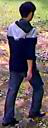

In [ ]:
for path in input_path:
  img=Image.open(path[0])
  display(img)

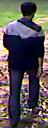

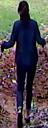

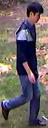

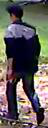

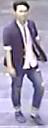

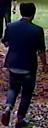

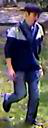

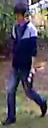

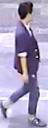

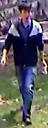

In [ ]:
for path in output_paths:
  img=Image.open(path[0])
  display(img)